In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,6)

import scipy
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
tfk = tf.keras
tf.keras.backend.set_floatx("float64")
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

tfd = tfp.distributions

In [45]:
gal_df = pd.read_csv("Data/galaxies_near_clusters_0.3-0.6.csv") 
cluster_data = pd.read_csv("Data/cluster_data_0.3-0.6.csv")
x=cluster_data["stellarmass"]; 
y=cluster_data["halo_mass"];

## Case 2: Aleatoric Uncertainty

Oct 8 2021

In [40]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [31]:
# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1 + 1),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[ 0.88022363 -2.8858604 ]
[ 3.444117  -2.6726418]


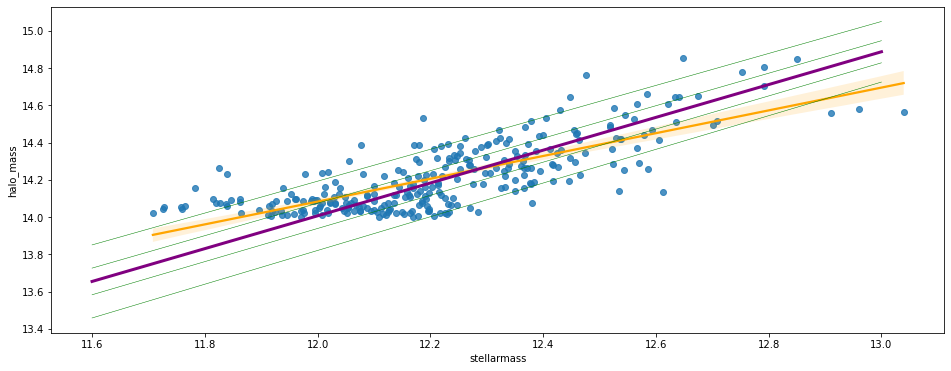

In [32]:
x_tst=np.arange(11.6,13,0.1)
x_tst=x_tst[:,None]
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)


sns.regplot(x="stellarmass",y="halo_mass", data=cluster_data, line_kws={"color": "orange"})
#sns.lineplot(x=xf,y=yhat[:,0], color="purple")
plt.plot(x_tst, yhat.mean(),'purple', label='mean', linewidth=3);
plt.plot(x_tst, yhat.quantile(0.32),'g',linewidth=0.5);
plt.plot(x_tst, yhat.quantile(0.68),'g',linewidth=0.5);
plt.plot(x_tst, yhat.quantile(0.10),'g',linewidth=0.5);
plt.plot(x_tst, yhat.quantile(0.90),'g',linewidth=0.5);

## Case 4: Aleatoric & Epistemic Uncertainty

In [33]:
#Epistemic uncertainty model

# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

In [34]:
#Epistemic uncertainty model

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

In [35]:
# Build model.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[ 1.0520428  -3.4075716   1.3252754  -2.9849408  -5.2023907  -0.44105676
 -3.7859929   0.01413638]
[ 1.0539534 -3.1590807  1.33364   -2.8564687]


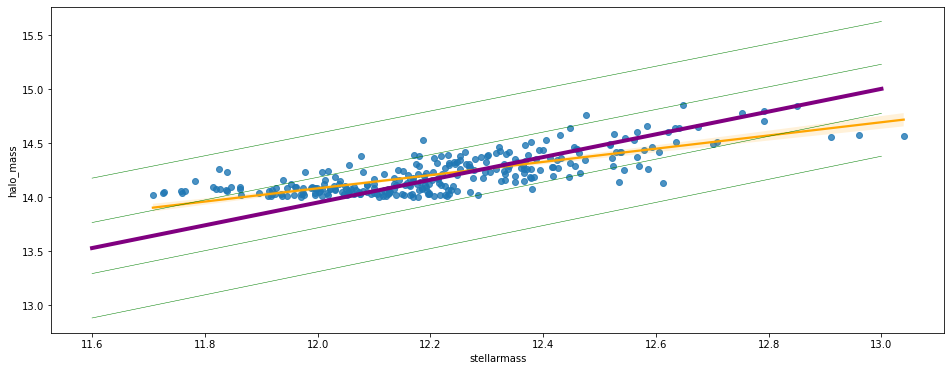

In [37]:
sns.regplot(x="stellarmass",y="halo_mass", data=cluster_data, line_kws={"color": "orange"})

yhats = [model(x_tst) for _ in range(2000)]
avgm = np.zeros_like(x_tst[..., 0])
s1m = np.zeros_like(x_tst[..., 0])
s2m = np.zeros_like(x_tst[..., 0])
s3m = np.zeros_like(x_tst[..., 0])
s4m = np.zeros_like(x_tst[..., 0])

for i, yhat in enumerate(yhats):
  m = np.squeeze(yhat.mean())
  s1 = np.squeeze(yhat.quantile(0.32))
  s2 = np.squeeze(yhat.quantile(0.68))
  s3 = np.squeeze(yhat.quantile(0.10))
  s4 = np.squeeze(yhat.quantile(0.90))
#  if i < 15:
#    plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=1.)
#    plt.plot(x_tst, s2, 'g', linewidth=0.5, label='ensemble means + 1 ensemble stdev' if i == 0 else None);
#    plt.plot(x_tst, s1, 'g', linewidth=0.5, label='ensemble means - 1 ensemble stdev' if i == 0 else None);
  avgm += m
  s1m += s1
  s2m += s2
  s3m += s3
  s4m += s4
plt.plot(x_tst, avgm/len(yhats), 'purple', label='overall mean', linewidth=4)
plt.plot(x_tst, s1m/len(yhats), 'g',linewidth=0.5)
plt.plot(x_tst, s2m/len(yhats), 'g',linewidth=0.5)
plt.plot(x_tst, s3m/len(yhats), 'g',linewidth=0.5)
plt.plot(x_tst, s4m/len(yhats), 'g',linewidth=0.5)

## Following George Tancev in Baysean Neural Networks with TensorFlow Probability

In [41]:
# Define helper functions.
scaler = StandardScaler()
detector = IsolationForest(n_estimators=1000,  contamination="auto", random_state=0)
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [86]:
xname="sm_0.67"; yname="halo_mass"
x=cluster_data[xname]; 
y=cluster_data[yname];

unit_df =pd.DataFrame(data={"x":x,"y":y}) 
#print(unit_df)
print(unit_df.shape)

# Scale data to zero mean and unit variance.
X_t = scaler.fit_transform(unit_df)
# Remove outliers.
detector = IsolationForest(n_estimators=1000,  contamination=0.05, random_state=0)
is_inlier = detector.fit_predict(X_t)
X_t = X_t[(is_inlier > 0),:]
#X_t = scaler.fit_transform(X_t)

unit_df = pd.DataFrame(X_t, columns=[xname,yname])
#print(unit_df)
print(unit_df.shape)

(287, 2)
(272, 2)


<AxesSubplot:xlabel='sm_0.67', ylabel='halo_mass'>

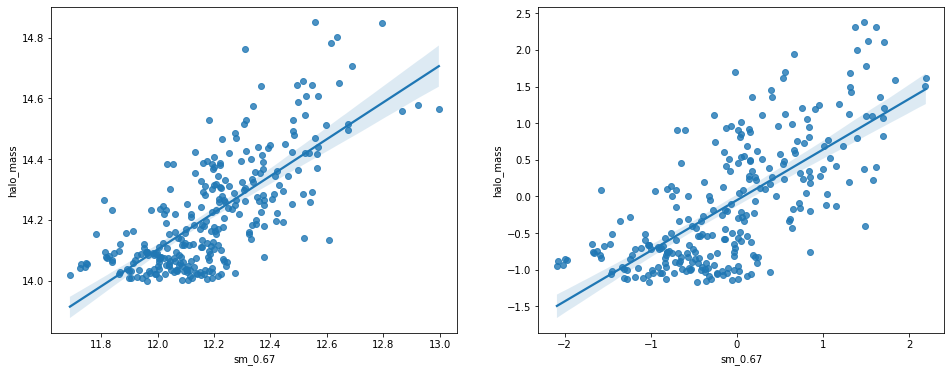

In [87]:
fig, (ax1,ax2) = plt.subplots(1,2)
sns.regplot(x=xname,y=yname,data=cluster_data,ax=ax1)
sns.regplot(x=xname,y=yname,data=unit_df,ax=ax2)

[12.18874179 14.21663648] [0.04919347 0.03418221]
(272,)
(272, 2)


<AxesSubplot:>

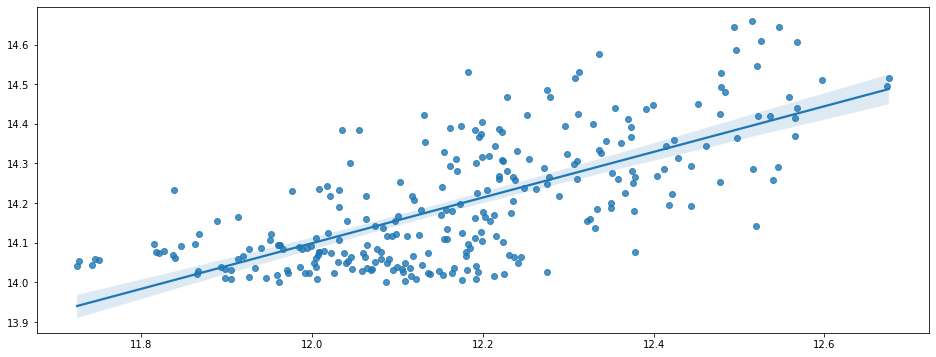

In [109]:
#s=scaler.fit_transfom(X_t)
print(scaler.mean_,scaler.var_)
xx=scaler.inverse_transform(X_t)
print(xx[:,0].shape)
xxx=xx[:,0]
xxy=xx[:,1]
print(xx.shape)
sns.regplot(x=xxx, y = xxy)

### Data Handling

TensorFlow offers a dataset class to construct training and test sets. We shall use 70% of the data as training set. The sets are shuffled and repeating batches are constructed.

In [112]:
dataset=unit_df
inputs = [xname,]
outputs = [yname,]
# Define some hyperparameters.
n_epochs = 50
n_samples = dataset.shape[0]
n_batches = 10
batch_size = np.floor(n_samples/n_batches)
buffer_size = n_samples

# Define training and test data sizes.
n_train = int(0.7*dataset.shape[0])

# Define dataset instance.
data = tf.data.Dataset.from_tensor_slices((dataset[inputs].values, dataset[outputs].values))
data = data.shuffle(n_samples, reshuffle_each_iteration=True)

# Define train and test data instances.
data_train = data.take(n_train).batch(batch_size).repeat(n_epochs)
data_test = data.skip(n_train).batch(1)

### Model Building
#### Aleotoric Uncertainty

To account for aleotoric uncertainty, which arises from the noise in the output, dense layers are combined with probabilistic layers. More specifically, the mean and covariance matrix of the output is modelled as a function of the input and parameter weights. 

The first hidden layer shall consist of ten nodes, the second one needs four nodes for the means plus ten nodes for the variances and covariances of the four-dimensional (there are four outputs) multivariate Gaussian posterior probability distribution in the final layer. This is achieved using the params_size method of the last layer (MultivariateNormalTriL), which is the declaration of the posterior probability distribution structure, in this case a multivariate normal distribution in which only one half of the covariance matrix is estimated (due to symmetry). The total number of parameters in the model is 224 — estimated by variational methods. The deterministic version of this neural network consists of an input layer, ten latent variables (hidden nodes), and an output layer (114 parameters), which does not include the uncertainty in the parameters weights.

In [113]:
# Define prior for regularization.
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(len(outputs), dtype=tf.float64), scale=1.0), reinterpreted_batch_ndims=1)

In [119]:
# Define model instance.
model = tfk.Sequential([
tfk.layers.InputLayer(input_shape=(len(inputs),), name="input"),
    # just one output mean, var, so 10->2
tfk.layers.Dense(2, activation="relu", name="dense_1"),
tfk.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(
len(outputs)), activation=None, name="distribution_weights"),
tfp.layers.MultivariateNormalTriL(len(outputs), activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1/n_batches), name="output")
], name="model")

In [120]:
# Compile model.
model.compile(optimizer="adam", loss=neg_log_likelihood)

In [121]:
# Run training session.
history=model.fit(data_train, epochs=n_epochs, validation_data=data_test, verbose=False)

In [122]:
# Describe model.
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 4         
_________________________________________________________________
distribution_weights (Dense) (None, 2)                 6         
_________________________________________________________________
output (MultivariateNormalTr multiple                  0         
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


The activity_regularizer argument acts as prior for the output layer (the weight has to be adjusted to the number of batches). The training session might take a while depending on the specifications of your machine. The algorithm needs about 50 epochs to converge (Figure 2).

dict_keys(['loss', 'val_loss'])


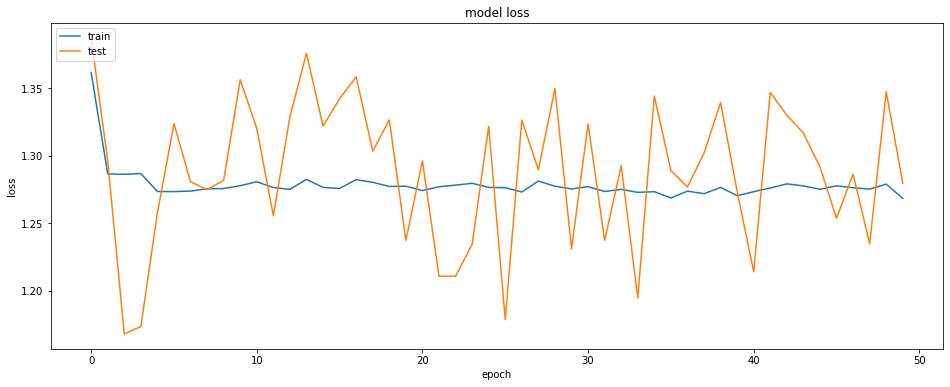

In [123]:
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Aleotoric and Epistemic Uncertainty

To account for aleotoric and epistemic uncertainty (uncertainty in parameter weights), the dense layers have to be exchanged with Flipout layers (DenseFlipout) or with Variational layers (DenseVariational). Such a model has more parameters, since every weight is parametrized by normal distribution with non-shared mean and standard deviation, hence doubling the amount of parameter weights. 
Weights will be resampled for different predictions, and in that case, the Bayesian neural network will act like an ensemble.

In [124]:
# 10 -> 2
tfp.layers.DenseFlipout(10, activation="relu", name="dense_1")

The default prior distribution over weights is tfd.Normal(loc=0., scale=1.) and can be adjusted using the kernel_prior_fn argument.

On flipouts: https://arxiv.org/abs/1803.04386

### Prediction

Since it is a probabilistic model, a Monte Carlo experiment is performed to provide a prediction. In particular, every prediction of a sample x results in a different output y, which is why the expectation over many individual predictions has to be calculated. Additionally, the variance can be determined this way.

In [140]:
print(features, labels, "xxx", X_true.shape)

tf.Tensor([[-0.32033844]], shape=(1, 1), dtype=float64) tf.Tensor([[0.00765343]], shape=(1, 1), dtype=float64) xxx (100, 1)


In [141]:
# Predict.
samples = 50
iterations = 50
test_iterator = tf.compat.v1.data.make_one_shot_iterator(data_test)
X_true, Y_true, Y_pred = np.empty(shape=(samples, len(inputs))), \
    np.empty(shape=(samples, len(outputs))), np.empty(shape=(samples, len(outputs), iterations))
for i in range(samples):
    features, labels = test_iterator.get_next()
    X_true[i,:] = features
    Y_true[i,:] = labels.numpy()
    for k in range(iterations):
        Y_pred[i,:,k] = model.predict(features)
        
# Calculate mean and standard deviation.
Y_pred_m = np.mean(Y_pred, axis=-1)
Y_pred_s = np.std(Y_pred, axis=-1)

In [142]:
print(Y_pred_m.shape, Y_pred_s.shape, Y_true.shape, X_true.shape)

(50, 1) (50, 1) (50, 1) (50, 1)


<AxesSubplot:>

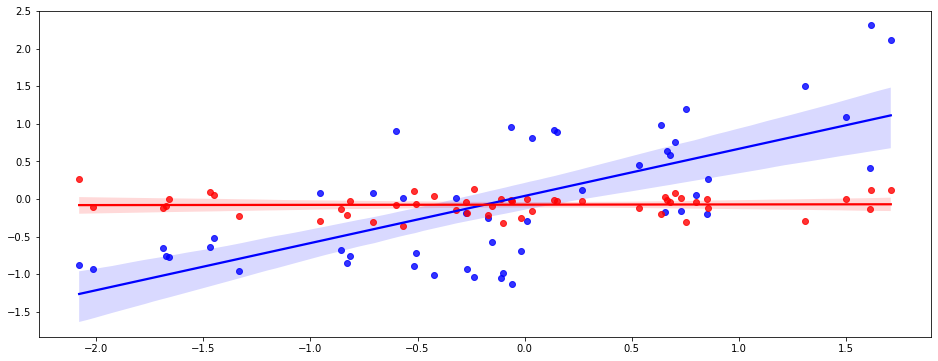

In [143]:
sns.regplot(x=X_true, y= Y_true,color="b")
sns.regplot(x=X_true, y= Y_pred_m,color="r")